In [30]:
import os
import numpy as np
import random
import torch
import glob
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets
from scipy.io import loadmat
import pathlib
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.measure import compare_psnr

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def activation_layer(activation:str):

    if activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)


In [5]:
def normalization_layer(normalization: str,
                      num_channels: int, dim:int):
    if dim == 2:
        if normalization == 'BN':
            return nn.BatchNorm2d(num_channels)
    elif dim == 3:
        if normalization == 'BN':
            return nn.BatchNorm3d(num_channels)


In [6]:
def pooling_layer(pooling:str, dim:int):
    if dim == 2:
        if pooling == "max":
            return nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        elif pooling == 'avg':
            return nn.AvgPool2d(kernel_size=2,stride=2,padding=0)

    if dim == 3:
        if pooling == "max":
            return nn.MaxPool3d(kernel_size=2,stride=2,padding=0)
        elif pooling == 'avg':
            return nn.AvgPool3d(kernel_size=2,stride=2,padding=0)


In [7]:
def conv_layer(in_chs, out_chs, kernel_size, stride, padding, dim):
    if dim == 2:
        return nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
    elif dim == 3:
        return nn.Conv3d(in_chs, out_chs, kernel_size, stride, padding)

In [8]:
def up_sample_layer(up_sample,in_chs = None, out_chs = None, kernel_size = 2, stride = 2, dim = 3):
    if up_sample == 'transposed':
        if dim == 2:
            return nn.ConvTranspose2d(in_chs, out_chs, kernel_size,stride)
        elif dim == 3:
            return nn.ConvTranspose3d(in_chs, out_chs, kernel_size,stride)
    else:
        return nn.Upsample(scale_factor=2, mode=up_sample) # mode can be 'nearest', 'bilinear' ,...

In [9]:
def Cat(tensor1, tensor2):
    
    x = torch.cat((tensor1, tensor2), 1)

    return x

In [10]:
def Add (tensor1, tensor2):
    
    x = torch.add(tensor1, tensor2)
    
    return x

In [17]:
class DownBlock(nn.Module):
    """
    represent a block from the left part of  U shape.
    it contains two convolution layers, 
    each followed by a batch normalization (BN) and a leaky rectified,
    and a downsampling layer followed by a BN and leakyRElu
      
    
    """

    def __init__(self,
                 in_ch,
                 out_ch,
                 stride_pooling:bool,
                 pooling: str = "max",     
                 kernel_size: int = 3,
                 stride:int = 1,
                 padding: int = 1,
                 activation: str = 'leaky',
                 normalization: str = 'BN',
                 dim: int = 2
                 ):
        super().__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.pooling = pooling
        self.stride_pooling = stride_pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.activation_layer = activation_layer(self.activation)
        self.normalization_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim)       
        self.pooling_layer = pooling_layer(pooling = self.pooling, dim=self.dim)
        self.stride_layer = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = 2, padding = self.padding, 
                                          dim = self.dim)      
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
        x = self.conv_layer2(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
        connect_layer = x
        if self.stride_pooling:
            x = self.stride_layer(x)            
        else:
            x =  self.pooling_layer(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
                                                       
        return x,connect_layer


In [11]:
def crop(down_level, up_level):
    """
    the input down_level is each level's last tensor on the left (down) side. e.g. [1,1,256,256,64]; up_level is the first
    tensor on the right (up) side.
    Center-crops the encoder_layer to the size of the decoder_layer,
    so can catanate encoder layer to decoder layer
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if down_level.shape[2:] != up_level.shape[2:]:
        down_shape = down_level.shape[2:]
        up_shape = up_level.shape[2:]
        #down_shape should bigger than up_shape
        if down_level.dim() == 4:  # 2D
            down_level = encoder_layer[
                            :,
                            :,
                            ((down_shape[0] - up_shape[0]) // 2):((down_shape[0] + up_shape[0]) // 2),
                            ((down_shape[1] - up_shape[1]) // 2):((down_shape[1] + up_shape[1]) // 2)
                            ]
        elif down_level.dim() == 5:  # 3D
            down_level = down_level[
                            :,
                            :,
                            ((down_shape[0] - up_shape[0]) // 2):((down_shape[0] + up_shape[0]) // 2),
                            ((down_shape[1] - up_shape[1]) // 2):((down_shape[1] + up_shape[1]) // 2),
                            ((down_shape[2] - up_shape[2]) // 2):((down_shape[2] + up_shape[2]) // 2),
                            ]
    return down_level, up_level


In [12]:
class Latent(nn.Module):
    """
    Latent, also called bottleneck, represents the bottom middle part of the UNet.
    In this work, it contains a conv+BN+LeakyRelu + conv+BN+LeakyRelu.
    """
    def __init__(self,
                 in_ch,
                 out_ch,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 2

                 ):
        super().__init__()

        self.in_ch =in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.activation_layer = activation_layer(self.activation)
        self.norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim) 
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)          
        self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.norm_layer(x)
        x = self.activation_layer(x)
        x = self.conv_layer2(x)
        x = self.norm_layer(x)
        x = self.activation_layer(x)
        
        return x
        


In [13]:
class UpBlock(nn.Module):
    """
    it corresponds to "red arrow+blue arrow+ blue arrow", i.e.
    [decon_layer (half the number of channels)+ Upsampling (double image size)]+
    [conv+bn+leaky]+[con+bn+leaky]
    """

    def __init__(self,
                 in_ch,
                 out_ch,
                 concatenate:bool = False,
                 add : bool = False,
                 Crop:bool = False,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.in_ch =in_ch
        self.out_ch = out_ch
        self.concatenate = concatenate
        self.add = add
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.up_sample = up_sample
        self.Crop = Crop
        

    
        self.activation_layer = activation_layer(self.activation)
     
        self.up_sample_layer = up_sample_layer(up_sample = self.up_sample)
        
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        if self.add:
            self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        elif self.concatenate:
            self.conv_layer2 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
            self.conv_layer3 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim)        
            
    def forward(self, x, connect_layer):

        #deconv + upsample
        x = self.conv_layer1(x) #128 -> 64
        x = self.up_sample_layer(x) # 32*32 -> 64*64
        
        #merge
        if self.concatenate:
            x = Cat(connect_layer,x) #64 -> 128
            x = self.conv_layer2(x) #128->64
            x = self.norm_layer(x) 
            x = self.activation_layer(x)
            x = self.conv_layer3(x) #64 -> 64
            x = self.norm_layer(x)
            x = self.activation_layer(x)
            
        elif self.add:
            x = Add(connect_layer,x)
        
            #conv+bn+lrelu
            x = self.conv_layer2(x)
            x = self.norm_layer(x)
            x = self.activation_layer(x)
            #conv+bn+lrelu
            x = self.conv_layer2(x)
            x = self.norm_layer(x)
            x = self.activation_layer(x)
        
        

        return x


In [14]:
class last_block(nn.Module):
    """
    it's the last block of layers after the UpBlock to make channel 16 into channel 1.
    it contains conv+bn+leakyRelu
    """
    def __init__(self,
                 in_ch,
                 out_ch,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 2

                 ):
        super().__init__()
        
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.conv_layer_final = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.norm_layer_final = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim) 
        
        
        
    def forward(self,x):

        x = self.conv_layer_final(x)
        x = self.norm_layer_final(x)
        #x = act_layer(x)
        #x = nn.Sigmoid()(x)
        #x = nn.Linear(256,256)(x)
        return x
    
    

In [15]:
class UNet(nn.Module):
    """
    it combines DownBlock + middle bottom of U shape + UpBlock + the final conv_layer.
    we want to follow the UNet from the paper, so  here depth is 3, which means
    the UNet will first run DownBlock for three times,
    then reach the bottom, and will run "conv+bn+leaky" +"conv+bn+leaky",
    then will run UpBlock for three times,
    then we add the last layer to make channels from 16 -> 1

    """
    def __init__(self,
                 stride_pooling:bool,
                 chs = [1,16,32,64,128],
                 concatenate:bool = False,
                 add:bool = False,
                 Crop:bool=False,
                 pooling = "max",
                 
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.chs = chs
        self.depth = len(chs)-2
        self.pooling = pooling
        self.stride_pooling = stride_pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.concatenate = concatenate
        self.add = add
        self.up_sample = up_sample
        self.Crop = Crop
        
        
        self.encoder = nn.ModuleList([])
        self.decoder = nn.ModuleList([])
        self.latent = Latent(in_ch = self.chs[-2],
                             out_ch = self.chs[-1],
                             kernel_size = self.kernel_size,
                             stride = self.stride,
                             padding = self.padding,
                             activation = self.activation,
                             normalization = self.normalization,
                             dim = self.dim)
        self.last_block = last_block(in_ch = self.chs[1],
                             out_ch = self.chs[0],
                             kernel_size = self.kernel_size,
                             stride = self.stride,
                             padding = self.padding,
                             activation = self.activation,
                             normalization = self.normalization,
                             dim = self.dim)
        
        for i in range(self.depth):
            encoder_layer = DownBlock(
                 in_ch=self.chs[i],
                 out_ch=self.chs[i+1],
                 #concatenate = True,
                 stride_pooling = self.stride_pooling,
                 pooling = self.pooling,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation = self.activation,
                 normalization = self.normalization,
                 dim= self.dim)
            
            self.encoder.append(encoder_layer) #encoder is the modulelist, and it appends each downblocks
            
            decoder_layer = UpBlock(
                 in_ch = self.chs[-1-i],
                 out_ch = self.chs[-2-i],
                 concatenate= self.concatenate,
                 add = self.add,
                 Crop=self.Crop,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation= self.activation,
                 normalization = self.normalization,
                 dim = self.dim,
                 up_sample= self.up_sample) 
            
            self.decoder.append(decoder_layer)
            
        self.set_weights()
        

    @staticmethod        
    def weight_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            #nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('Sigmoid') != -1:
            nn.init.xavier_normal(m.weight)
        #elif classname.find('Leaky') != -1:
            #nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
   
    def set_weights(self):
        for i,m in enumerate(self.modules()):
            self.weight_init(m)
            
        
    def forward(self,x):
        connect_list = [] #it contains the layer from encoder path which need to skip to connect
        
        #encoder path
        for i in range(self.depth):
            block = self.encoder[i]
            x,connect_layer = block(x)
            connect_list.append(connect_layer)
            
        #bottom block: the middle and bottom part of UNet
        
        x = self.latent(x)
        
        #decoder path
        for i in range(self.depth):
            layer_to_connect = connect_list[-1-i]
            block = self.decoder[i]
            x = block(x,layer_to_connect)
            
        #last layer : 16 to 1
        x = self.last_block(x)
        
        
            
        return x
                
            

In [18]:
unet = UNet(stride_pooling = True,
                 chs = [1,16,32,64,128],
                 concatenate= False,
                 add = True,
                 Crop=False,
                 pooling = "max",
                 
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation= 'leaky',
                 normalization = "BN",
                 dim= 2,
                 up_sample= 'nearest')

C:\Users\h\anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [99]:
tt = torch.randn(1,1,256,256)
t = unet(tt)
t.shape

torch.Size([1, 1, 256, 256])

In [100]:
from torchsummary import summary
summary(unet, (1,256,256), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 256, 256]             160
       BatchNorm2d-2          [1, 16, 256, 256]              32
         LeakyReLU-3          [1, 16, 256, 256]               0
            Conv2d-4          [1, 16, 256, 256]           2,320
       BatchNorm2d-5          [1, 16, 256, 256]              32
         LeakyReLU-6          [1, 16, 256, 256]               0
            Conv2d-7          [1, 16, 128, 128]           2,320
       BatchNorm2d-8          [1, 16, 128, 128]              32
         LeakyReLU-9          [1, 16, 128, 128]               0
        DownBlock-10  [[-1, 16, 128, 128], [-1, 16, 256, 256]]               0
           Conv2d-11          [1, 32, 128, 128]           4,640
      BatchNorm2d-12          [1, 32, 128, 128]              64
        LeakyReLU-13          [1, 32, 128, 128]               0
           Conv2d-14    

In [ ]:
torch.save(model_unet, "UNet.pth")



In [ ]:
model_unet = torch.load("UNet.pth")

# upload image and noise

In [53]:
def upload_image(file_name):
    P = loadmat(file_name)
    p = P['data']
    p1 = p[:,:,120,2] #this give the chest image at time 2
    P1= torch.from_numpy(p1)
    P1 = (P1-P1.min())/(P1.max()-P1.min()) #scale P1 to (0,1)
    P1 = P1.unsqueeze(0)
    P1 = P1.unsqueeze(0)

    poi_noise = torch.poisson(P1)*0.1
    p_noise = P1+poi_noise
    
    return P1,p_noise
    

In [54]:
P1,p_noise = upload_image('xcat.mat')
uniform_noise = torch.randn(1,1,256,256)


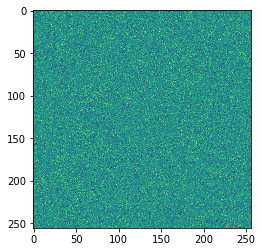

In [37]:
plt.imshow(uniform_noise[0,0,:,:])

# set random seed

In [ ]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()


# save the output images


In [ ]:
def save_output_img(output_img,epoch,train_loss,psnr):

    fig = plt.figure()
    ax = fig.add_subplot(111)   
    plot = plt.imshow(output_img[0,0,:,:])
    plt.clim(0,1)
    plt.title('Epoch: {}, Training Loss: {:.6f}, PSNR: {:.6f}'.format(epoch+1, train_loss,psnr))

    plt.savefig(path+'output_image{}.png'.format(epoch+1))
    plt.close(fig)#not display the image

# train function

In [25]:
def optim(optimizer:str = 'Adam'):
    if optimizer == 'Adam':
        return Adam(model.parameters(), lr=1e-3)
    elif optimizer == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
def loss(criterion:str = 'MSE'):
    if criterion == 'MSE':
        return nn.MSELoss()

In [77]:
def train_setup(model,criterion_name,optimizer_name,input_image,label_image,epoch):
    optimizer = optim(optimizer_name)
    criterion = loss(criterion_name)


    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        
    def train(epoch):
    #strat TRAIN mode
        model.train()
        train_loss = 0.0
        
        x_train, label= Variable(input_image), Variable(label_image)
    

        if torch.cuda.is_available():
        
            x_train = x_train.cuda()           
            label = label.cuda()
    
        optimizer.zero_grad()
        output = model(x_train)
        output_img = output.detach().numpy()
        
        loss = criterion(output,label)
    #compute gradient
        loss.backward()
    #update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()    
         
    
        train_loss = loss.item()
        loss_list.append(train_loss)
        
        psnr = compare_psnr(label_image.numpy(), output_img,1)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tPSNR: {:.6f}'.format(epoch, train_loss,psnr))
        
        
        if (epoch+1) %200 == 0:  #this only display the output of tevery 200 iteration
            #fig.add_subplot(3,4,(epoch+1)/200)
            #plt.imshow(output_img[0,0,:,:])
            #plt.clim(0,1)
            
            save_output_img(output_img,epoch,train_loss,psnr)
            
    
    return train(epoch)
    
 

#  training process

In [40]:
model = unet
#model = unet
criterion_name = 'MSE'

optimizer_name = 'Adam'
#input_image = p_noise
#input_image = P1
input_image = uniform_noise
label_image = P1

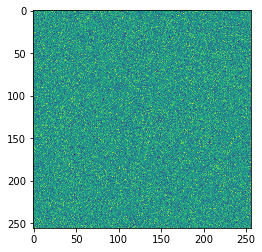

In [30]:
plt.imshow(uniform_noise[0,0,:,:])

# create a folder for all the output images

In [65]:
path = 'xcat_output/'
os.makedirs(path)

# iterate the training

In [78]:
num_epochs = 2000
train_loss = 0
loss_list = []
#rows = math.ceil(num_epochs/4)
#fig = plt.figure(figsize=(rows*3,4*3))
fig = plt.figure(figsize=(24,24))

#fig.tight_layout()
#plt.subplots_adjust(wspace =0, hspace =0)

for epoch in range(num_epochs):
    train_setup(model,criterion_name,optimizer_name,input_image,label_image,epoch)
    #plt.imshow(output_img[0,0,:,:])
    #ax.set_title(classes[train_labels[idx]])
    #train1(epoch)
#draw loss plot
#plt.plot(loss_list,label='Training loss')

C:\Users\h\anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


Epoch: 0 	Training Loss: 0.011421 	PSNR: 19.422996
Epoch: 1 	Training Loss: 0.011207 	PSNR: 19.505267
Epoch: 2 	Training Loss: 0.010998 	PSNR: 19.586958
Epoch: 3 	Training Loss: 0.010787 	PSNR: 19.670951
Epoch: 4 	Training Loss: 0.010583 	PSNR: 19.753955
Epoch: 5 	Training Loss: 0.010376 	PSNR: 19.839537
Epoch: 6 	Training Loss: 0.010176 	PSNR: 19.924215
Epoch: 7 	Training Loss: 0.009974 	PSNR: 20.011289
Epoch: 8 	Training Loss: 0.009779 	PSNR: 20.097090
Epoch: 9 	Training Loss: 0.009580 	PSNR: 20.186513
Epoch: 10 	Training Loss: 0.009389 	PSNR: 20.273996
Epoch: 11 	Training Loss: 0.009194 	PSNR: 20.365126
Epoch: 12 	Training Loss: 0.009007 	PSNR: 20.454009
Epoch: 13 	Training Loss: 0.008817 	PSNR: 20.547001
Epoch: 14 	Training Loss: 0.008631 	PSNR: 20.639305
Epoch: 15 	Training Loss: 0.008445 	PSNR: 20.734028
Epoch: 16 	Training Loss: 0.008260 	PSNR: 20.830089
Epoch: 17 	Training Loss: 0.008085 	PSNR: 20.923180
Epoch: 18 	Training Loss: 0.007898 	PSNR: 21.024875
Epoch: 19 	Training Lo

<Figure size 1728x1728 with 0 Axes>

# plot training loss

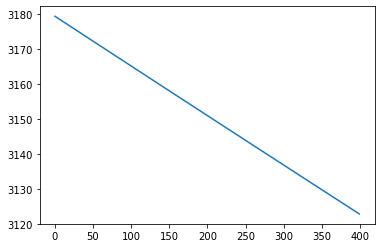

In [106]:
plt.plot(loss_list,label='Training loss')
plt.title('Training Loss)

plt.savefig(path+'loss.png')
plt.close(fig)#not display the image

